In [1]:
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow import keras
from pathlib import Path
import tensorflow as tf
import yfinance as yf
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
# Download historical stock data for a specific ticker
ticker = 'AAPL'
stock_data = yf.download(ticker, start='2015-01-01', end='2020-01-01')

[*********************100%%**********************]  1 of 1 completed


In [3]:
display(stock_data)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.347174,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.661276,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.663506,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,23.995312,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.917271,237458000
...,...,...,...,...,...,...
2019-12-24,71.172501,71.222504,70.730003,71.067497,68.898705,48478800
2019-12-26,71.205002,72.495003,71.175003,72.477501,70.265663,93121200
2019-12-27,72.779999,73.492500,72.029999,72.449997,70.238998,146266000


In [4]:
features = stock_data[['Close']]
target = stock_data['Close']  # Predicting next time step close price

In [5]:
scaler = MinMaxScaler()

In [6]:
features_scaled = scaler.fit_transform(features)

In [7]:
target_reshaped = target.values.reshape(-1, 1)

In [8]:
target_scaled = scaler.fit_transform(target_reshaped)

In [9]:
x = []
y = []
time_steps = 30

for i in range(time_steps, len(features_scaled)):
    x.append(features_scaled[i-time_steps:i])
    y.append(target_scaled[i])

X, y = np.array(x), np.array(y)

In [10]:
# Function to build and train a Long Short Term Memory Deep Learning memory
def BuildModel(X_train, y_train):
    model = Sequential()
    # Use Input layer to specify the shape
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    # Add LSTM layer
    model.add(LSTM(units=64, activation='relu'))
    # Output layer
    model.add(Dense(1))  # For regression (1 output)
    # Print model summary
    model.summary()
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Fit the model with the training data
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.3)

    return model

In [11]:
train_test_separation_index = int(len(stock_data)*0.8)

print(f"{train_test_separation_index = }")

train_test_separation_index = 1006


In [12]:
X_train, y_train = X[:train_test_separation_index], y[:train_test_separation_index]
X_test, y_test = X[train_test_separation_index:], y[train_test_separation_index:]

In [13]:
model = BuildModel(X_train, y_train)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - loss: 0.0154 - val_loss: 0.0035
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.2743e-04 - val_loss: 0.0078
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.4165e-04 - val_loss: 0.0031
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 2.4577e-04 - val_loss: 0.0036
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.5371e-04 - val_loss: 0.0032
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 2.0894e-04 - val_loss: 0.0019
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.8723e-04 - val_loss: 0.0024
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.3122e-04 - val_loss: 0.0020
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.9352e-04 - val_loss: 0.0014
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.8137e-04 - val_loss: 0.0017
Epoch 12/50
22/22 ━━━━━━━━

In [14]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.5984e-04
Test Loss: 0.0005609143408946693


In [15]:
# Make predictions
predictions_scaled = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


In [16]:
# reshape predictions
predictions_reshaped = predictions_scaled.reshape(-1, 1)

In [17]:
predictions = scaler.inverse_transform(predictions_reshaped)

print(predictions)

[[42.317875]
 [42.264122]
 [42.188065]
 [42.167904]
 [42.242744]
 [42.23206 ]
 [42.375824]
 [42.590374]
 [42.767773]
 [42.94292 ]
 [42.9338  ]
 [43.05301 ]
 [43.20343 ]
 [43.286568]
 [43.261093]
 [43.06905 ]
 [42.939236]
 [43.29894 ]
 [43.74883 ]
 [44.171883]
 [44.64272 ]
 [45.16873 ]
 [45.695084]
 [45.962902]
 [46.251293]
 [46.930683]
 [47.15006 ]
 [47.105858]
 [46.87175 ]
 [46.77985 ]
 [46.70873 ]
 [46.74406 ]
 [46.874374]
 [47.19708 ]
 [47.557503]
 [47.864193]
 [48.19063 ]
 [48.66235 ]
 [48.96362 ]
 [49.2564  ]
 [49.320587]
 [49.32739 ]
 [49.329277]
 [49.310535]
 [49.589767]
 [49.86172 ]
 [50.121723]
 [50.542625]
 [50.831383]
 [50.885807]
 [50.818073]
 [50.761364]
 [50.38266 ]
 [50.863495]
 [51.13965 ]
 [51.56617 ]
 [51.62939 ]
 [51.20416 ]
 [50.8465  ]
 [50.37945 ]
 [49.733883]
 [48.29247 ]
 [47.447124]
 [47.041092]
 [46.756447]
 [46.541004]
 [45.96909 ]
 [45.85378 ]
 [45.51905 ]
 [45.049423]
 [44.659172]
 [44.334023]
 [44.055515]
 [43.95336 ]
 [43.661926]
 [43.320724]
 [43.573895]

In [18]:
actuals = scaler.inverse_transform(y_test)

print(actuals)

[[42.70000076]
 [42.60499954]
 [42.73249817]
 [43.00749969]
 [42.76499939]
 [43.24250031]
 [43.55749893]
 [43.58250046]
 [43.71749878]
 [43.28749847]
 [43.74250031]
 [43.96250153]
 [43.88249969]
 [43.63000107]
 [43.125     ]
 [43.22750092]
 [44.72499847]
 [45.22750092]
 [45.42750168]
 [45.93249893]
 [46.52999878]
 [47.00500107]
 [46.63249969]
 [47.04000092]
 [48.77249908]
 [47.76250076]
 [47.18500137]
 [46.69749832]
 [47.11750031]
 [47.18000031]
 [47.48749924]
 [47.81000137]
 [48.50500107]
 [48.83750153]
 [48.92250061]
 [49.25      ]
 [50.02500153]
 [49.875     ]
 [50.15499878]
 [49.73749924]
 [49.71749878]
 [49.80749893]
 [49.8125    ]
 [50.78250122]
 [50.96500015]
 [51.13249969]
 [51.86999893]
 [51.79000092]
 [51.31999969]
 [51.07500076]
 [51.15250015]
 [50.16749954]
 [52.63000107]
 [52.28749847]
 [52.9375    ]
 [52.11999893]
 [50.71500015]
 [50.72499847]
 [50.18000031]
 [49.29499817]
 [46.43000031]
 [47.16500092]
 [47.72999954]
 [47.52000046]
 [47.25      ]
 [45.77249908]
 [46.65000

In [19]:
# Calculate Error Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate errors
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mse)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MSE: 1.4490870854463094
MAE: 0.9950066987458644
RMSE: 1.203780331059745


In [20]:
def plot_actual_vs_predicted(actuals, predictions):
    # Plot Predictions vs Actual values
    plt.figure(figsize=(10,6))
    plt.plot(actuals, label='Actual', color="green")
    plt.plot(predictions, label='Predicted', color="blue")
    plt.grid(True)
    plt.title('Actual vs Predicted')
    plt.xlabel('Sequential Day Number')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

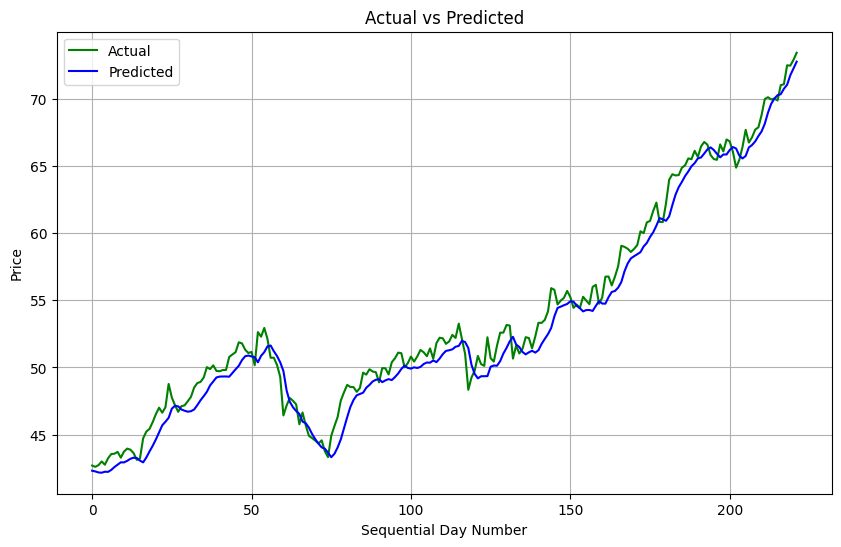

In [21]:
plot_actual_vs_predicted(
    actuals=actuals, 
    predictions=predictions
)

In [22]:
def plot_error_distribution(actuals, predictions):
    # Plot Error Distribution
    errors = actuals - predictions
    plt.figure(figsize=(10,6))
    plt.hist(errors, bins=50)
    plt.title('Prediction Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()

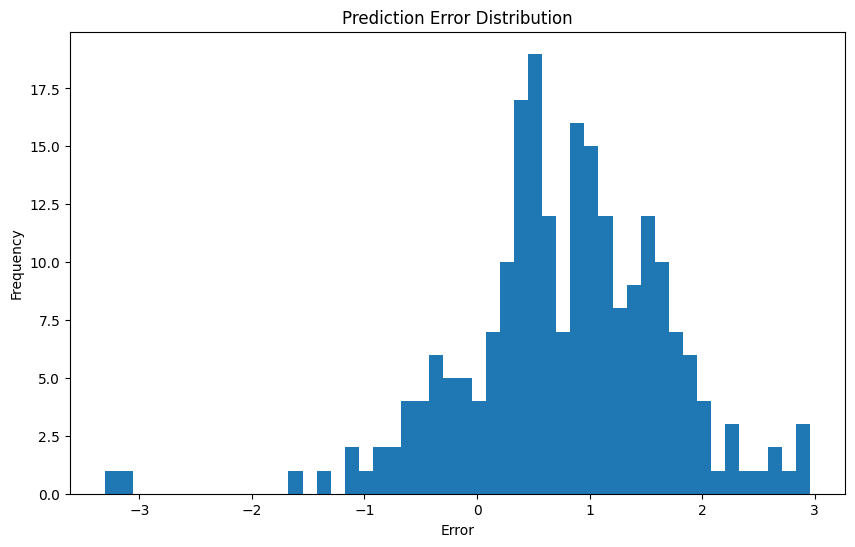

In [23]:
plot_error_distribution(
    actuals=actuals, 
    predictions=predictions
)

In [24]:
states = []

for index in range(1, len(predictions)):
    prev_actual = actuals[index-1][0]
    current_actual = actuals[index][0]
    actual_state = "Equal"
    if current_actual > prev_actual:
        actual_state = "Up"
    elif current_actual < prev_actual:
        actual_state = "Down"
    
    prev_prediction = predictions[index-1][0]
    current_prediction = predictions[index][0]
    prediction_state = "Equal"
    if current_prediction > prev_prediction:
        prediction_state = "Up"
    elif current_prediction < prev_prediction:
        prediction_state = "Down"

    state = {
        "prev_actual": prev_actual,
        "actual_state": actual_state,
        "current_actual": current_actual,

        "prev_prediction": prev_prediction,
        "prediction_state": prediction_state,
        "current_prediction": current_prediction,
    }
    states.append(state)

In [25]:
correctly_predicted = 0
up_predicted_actual_down = 0
up_predicted_actual_equal = 0
down_predicted_actual_up = 0
down_predicted_actual_equal = 0

def simulate_buy(before_balance, buy_price, sell_price):
    units_bought = before_balance/buy_price
    after_amount = units_bought*sell_price
    return after_amount

balance = 100
for index in range(len(states)):
    actual_state = states[index]["actual_state"]
    prediction_state = states[index]["prediction_state"]
    
    if actual_state == prediction_state and actual_state == "Up":
        correctly_predicted += 1

        after_balance = simulate_buy(
            before_balance=balance, 
            buy_price=states[index]["prev_actual"], 
            sell_price=states[index]["current_actual"]
        )       
        balance = after_balance

    elif actual_state == prediction_state and actual_state == "Down":
        correctly_predicted += 1

    elif actual_state == prediction_state and actual_state == "Equal":
        correctly_predicted += 1
        
    elif actual_state != prediction_state:
        if prediction_state == "Up" and actual_state == "Down":
            up_predicted_actual_down += 1

            after_balance = simulate_buy(
                before_balance=balance, 
                buy_price=states[index]["prev_actual"], 
                sell_price=states[index]["current_actual"]
            )       
            balance = after_balance

        elif prediction_state == "Up" and actual_state == "Equal":
            up_predicted_actual_equal += 1

            after_balance = simulate_buy(
                before_balance=balance, 
                buy_price=states[index]["prev_actual"], 
                sell_price=states[index]["current_actual"]
            )       
            balance = after_balance

        elif prediction_state == "Down" and actual_state == "Up":
            down_predicted_actual_up += 1

        elif prediction_state == "Down" and actual_state == "Equal":
            down_predicted_actual_equal += 1

    current_price = actuals[0][0]
    
print(f"{correctly_predicted = } --> winning")
print(f"{up_predicted_actual_down = } --> Losing if buying")
print(f"{up_predicted_actual_equal = } --> Break even if buying")
print(f"{down_predicted_actual_up = } --> Losing if selling")
print(f"{down_predicted_actual_equal = } --> Losing if selling")
print()

print(f"{balance = }")

correctly_predicted = 110 --> winning
up_predicted_actual_down = 68 --> Losing if buying
up_predicted_actual_equal = 0 --> Break even if buying
down_predicted_actual_up = 43 --> Losing if selling
down_predicted_actual_equal = 0 --> Losing if selling

balance = np.float64(134.6863575337563)
